# True Incrementality and Causality with Marketing Mix Modeling

## Introduction/Conclusion
Marketing Mix Modeling (MMM) is a powerful tool for understanding the effectiveness of marketing strategies. However, a common pitfall in MMM is the confusion between correlation and causation. The traditional wisdom for addressing this challenge and achieving true causal incrementality is through randomized control trials (RCTs) or Geo testing. While these methods are effective, they are also costly and time-consuming, often requiring significant resources and long timelines.

At MMM Labs, we believe that a better approach starts with using more sophisticated models—models that are designed to distinguish between correlation and causation from the outset. By applying advanced modeling techniques, we can provide more reliable estimates before running any experiments or Geo tests. This ensures that when you do invest in these traditional methods, you’re validating the most accurate and meaningful insights possible.

## Simulating the Data
To illustrate the issue, we simulate data that includes true marketing drivers (like TV and online ads) alongside a placebo variable—a random variable with no real impact on sales. This placebo serves as a test for our models: if a model mistakenly attributes significance to the placebo, it indicates a flaw in the method.
* **Sales**: The dependent variable.
* **Marketing Spend Variables**: Such as TV ads, online ads, and email campaigns.
* **Economic Indicators**: Like GDP or consumer sentiment.
* **Random Noise (Placebo Variable)**: A randomly generated variable that has no actual impact on sales.

Here’s a step-by-step guide to creating the data:

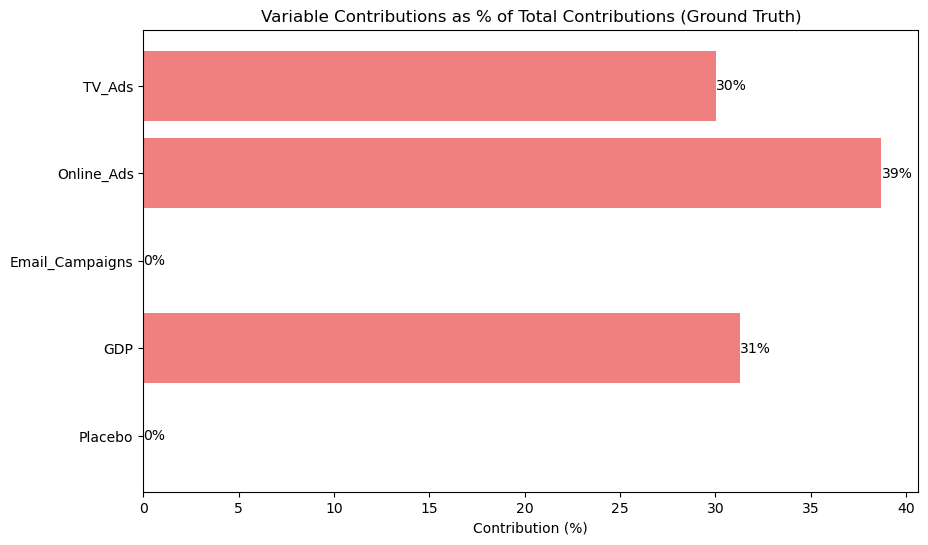

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Include helper functions
from plotting import *

np.random.seed(42)

# Simulate marketing spend and economic indicators
n = 100  # Number of data points
tv_ads = np.random.normal(200, 50, n)
online_ads = np.random.normal(150, 30, n)
email_campaigns = np.random.normal(100, 20, n)
gdp = np.random.normal(300, 40, n)

# Define the true coefficients for each variable
true_params = {
    'TV_Ads': 0.3,
    'Online_Ads': 0.5,
    'Email_Campaigns': 0.0,  # No contribution from Email Campaigns
    'GDP': 0.2,
    'Placebo': 0.0  # Placebo variable should have no true effect
}

# Simulate sales as a function of marketing spend and economic indicators
sales = (50 +
         true_params['TV_Ads'] * tv_ads +
         true_params['Online_Ads'] * online_ads +
         true_params['GDP'] * gdp +
         np.random.normal(0, 10, n))

# Create a new placebo variable with a stronger correlation to the noise in sales
placebo = 0.4 * sales + np.random.normal(0, 5, n)

# Create a DataFrame
df = pd.DataFrame({
    'Sales': sales,
    'TV_Ads': tv_ads,
    'Online_Ads': online_ads,
    'Email_Campaigns': email_campaigns,
    'GDP': gdp,
    'Placebo': placebo
})

# Plot Ground Truth
plot_contributions(df[['TV_Ads', 'Online_Ads', 'Email_Campaigns', 'GDP', 'Placebo']], 
                   true_params, 
                   model_name="Ground Truth")


## Analysis of Different Techniques

### Correlation Analysis
We begin with a simple correlation analysis, which shows the strength of the relationship between each variable and sales. While correlation can indicate a relationship, it doesn't tell us whether that relationship is truly causal.

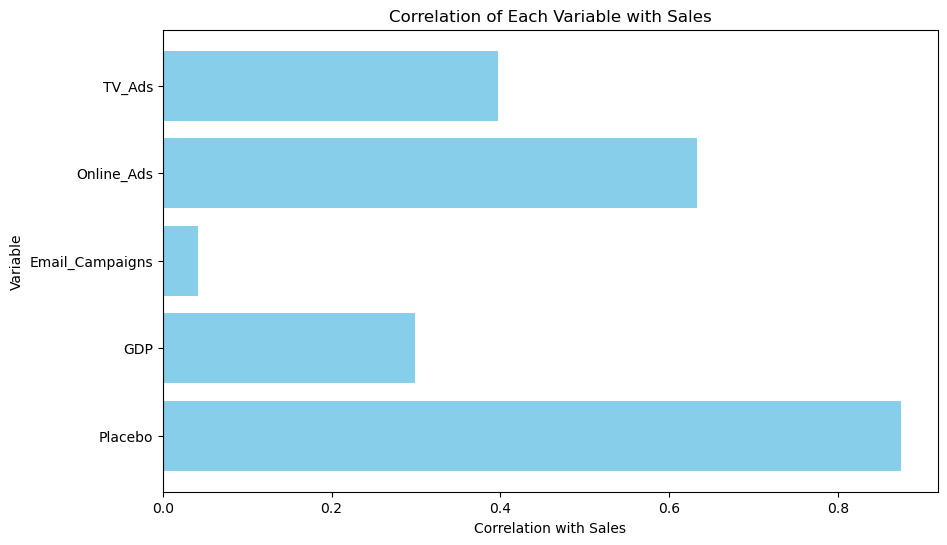

In [2]:
# Calculate the correlation of each variable with the sales variable
correlations = df.corr()['Sales'].drop('Sales')

# Plot the correlation as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(correlations.index[::-1], correlations.values[::-1], color='skyblue')
plt.xlabel('Correlation with Sales')
plt.ylabel('Variable')
plt.title('Correlation of Each Variable with Sales')
plt.show()

### Testing the OLS Model
Next, we apply OLS regression to the data. OLS is a traditional method often used in MMM. However, it tends to interpret correlations as causations, potentially giving the placebo variable an unwarranted significance. 

This method assigned 46% incremental results to our Placebo variable. The true value is 0%. It also incorrectly calculated the incremental effects of TV and Online ads. This is bad news for decision-makers.

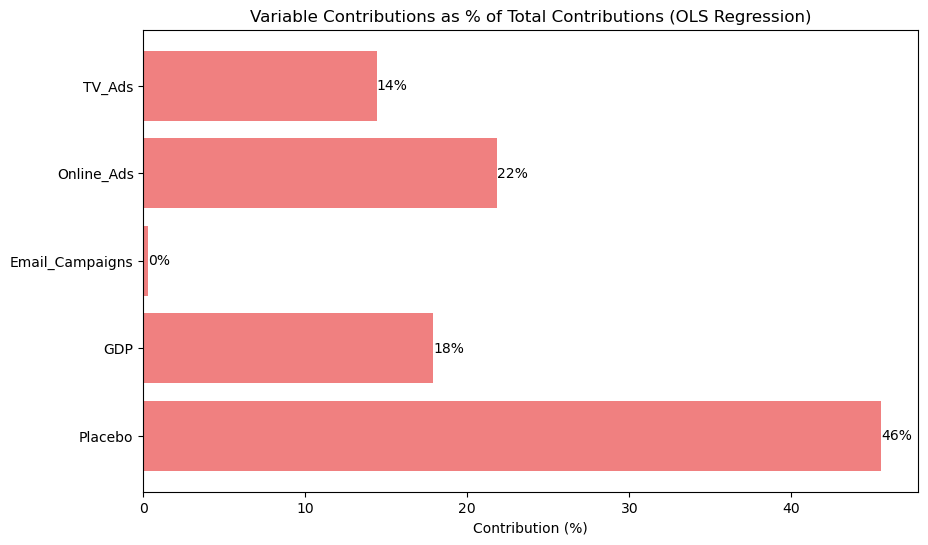

In [3]:
import statsmodels.api as sm

# Define the independent variables
features = df[['TV_Ads', 'Online_Ads', 'Email_Campaigns', 'GDP', 'Placebo']]
X = sm.add_constant(features)  # Adds a constant term to the model

# Define the dependent variable
y = df['Sales']

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()
ols_coefs = ols_model.params[1:]

plot_contributions(df[['TV_Ads', 'Online_Ads', 'Email_Campaigns', 'GDP', 'Placebo']], 
                   ols_coefs, 
                   model_name="OLS Regression")

# Combine contributions into a dictionary of lists
contributions = {
    'True Contributions': calculate_contributions(features, true_params),
    'OLS Regression': calculate_contributions(features, ols_model.params[1:])
}

### Testing with Advanced MMM
Now, we move on to a more sophisticated technique called Lasso regression, one of many that MMM Labs employs. This method is designed to differentiate between noise and true causal drivers, significantly reducing the risk of mistaking correlation for causation.

Not only did Lasso regression get the right results for the Placebo variable, it also got the correct estimation of TV, Online and GDP. And a bonus, Email marketing had zero effect (see the formulas above to verify).

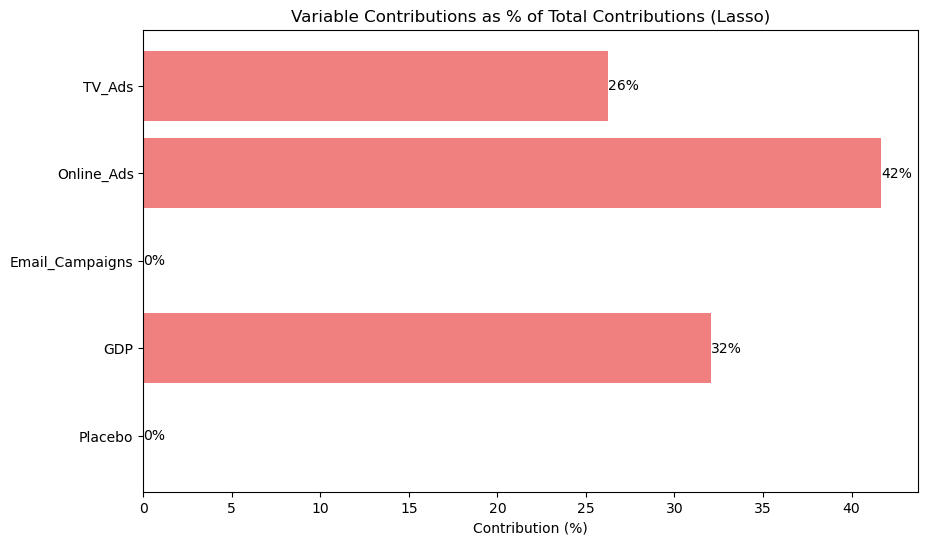

In [4]:
#from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
#from sklearn.linear_model import ElasticNet

# Define the independent variables
features = df[['TV_Ads', 'Online_Ads', 'Email_Campaigns', 'GDP', 'Placebo']]

# Define the dependent variable
y = df['Sales']

# Fit the Lasso regression model
lasso_model = Lasso(alpha=100)
lasso_model.fit(features, y)

# Extract the coefficients from the Lasso model
lasso_coefs = lasso_model.coef_

plot_contributions(df[['TV_Ads', 'Online_Ads', 'Email_Campaigns', 'GDP', 'Placebo']], 
                   lasso_coefs, 
                   model_name="Lasso")

## Putting it All Together
Finally, we compare the results across the methods: OLS regression, vs. Lasso regression. This comparison clearly shows that the advanced Lasso techniques can more accurately identify the true incremental impact of marketing activities, filtering out the noise (placebo) and focusing on what really drives results.

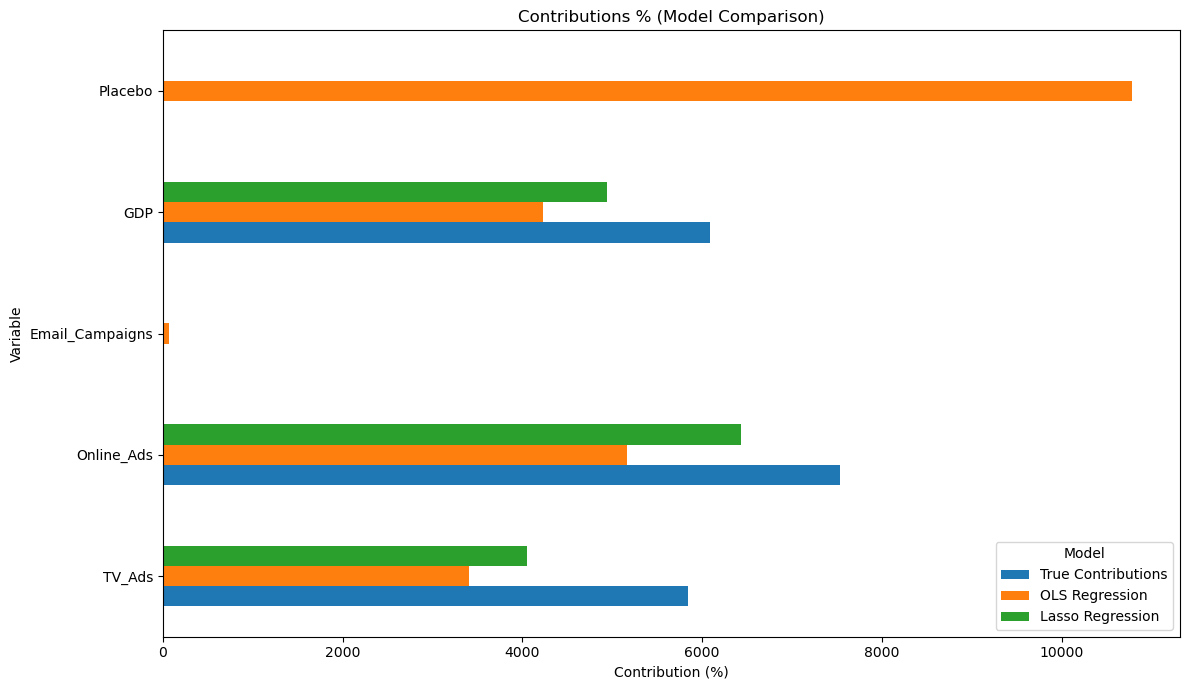

In [5]:
# Combine contributions into a dictionary of lists
contributions = {
    'True Contributions': calculate_contributions(features, true_params),
    'OLS Regression': calculate_contributions(features, ols_model.params[1:]),
    'Lasso Regression': calculate_contributions(features, lasso_model.coef_),
}

plot_multi_model_contributions(contributions, 
                   features.columns, 
                   model_name="Model Comparison")

## Call to Action
At MMM Labs, we are pushing the boundaries of Marketing Mix Modeling and incrementatlity estimation. Do you want to see how Meta's Robyn compares to Google's Lightweight MMM or Google's Meridian? [Book a demo with MMM Labs](https://www.mmmlabs.ai/book-a-demo) and discover how our advanced models can help you make better, data-driven decisions that truly reflect causality.

# DELETE ME

In [9]:
from pprint import pprint
pprint(calculate_contributions(features, lasso_model.coef_))

{'Email_Campaigns': np.float64(-0.0),
 'GDP': np.float64(4944.1506718047685),
 'Online_Ads': np.float64(6429.890797147065),
 'Placebo': np.float64(0.0),
 'TV_Ads': np.float64(4048.878603074218)}
